In [1]:
### Let's start by loading in the data, validating the data, and generating some basic stats

import pandas as pd

# Load the dataset
data = pd.read_csv('/nga_median_spend_model_train_da.csv')

# Display the first few rows of the dataset
data.head()

# Basic statistics
data_stats = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

data_stats, missing_values

(       Unnamed: 0  median_spend         lat        long  \
 count  541.000000  5.410000e+02  541.000000  541.000000   
 mean   314.922366  1.196646e+05    8.106825    7.063795   
 std    182.869761  1.178037e+05    2.407666    2.413368   
 min      1.000000  1.393600e+04    4.398427    2.879477   
 25%    159.000000  5.417250e+04    6.323147    5.048312   
 50%    311.000000  9.030000e+04    7.515147    7.081208   
 75%    476.000000  1.406850e+05    9.749818    8.465678   
 max    633.000000  1.092064e+06   13.714247   13.630725   
 
        accessibility_to_cities_2015  chirps_2015  chirps_average_2002_2015  \
 count                    541.000000   541.000000                541.000000   
 mean                       1.878275     3.687617               1531.359397   
 std                        1.905193     1.379831                646.157643   
 min                        0.100000     1.087242                363.812561   
 25%                        0.600304     2.742681              

Here are some basic descriptive statistics for each column:

**median_spend:** The average value is about 119,664 with a large standard deviation of 117,804, indicating a wide spread in the values. The minimum value is 13,936 and the maximum is 1,092,064.

**accessibility_to_cities_2015:** The average accessibility is approximately 1.88 with a maximum of 19.60, indicating that some regions are quite remote.

**chirps_2015 and chirps_average_2002_2015:** The average values are 3.69 and 1531.36 respectively. These could be related to rainfall or temperature, with the average values indicating generally moderate conditions.

**distance_to_ports_2012:** The average distance to ports is approximately 12.95 with a maximum of 37.50, indicating that some regions are quite far from ports.

**distance_to_powerplants_2016**: The average distance to powerplants is approximately 1.60 with a maximum of 7.30, indicating that some regions are quite far from powerplants.

**distance_to_roads_2015: **The average distance to roads is approximately 758.51, with a large standard deviation, indicating a wide spread in the values.

**distance_to_transmission_lines_2016:** The average distance to transmission lines is approximately 0.10 with a maximum of 1.25, indicating that some regions are quite far from transmission lines.

**landscan_population_2017:** The average population is approximately 3017.84 with a large standard deviation, indicating a wide spread in the population values.

modis_evi_2000_2016, modis_lst_day_average_2015, modis_lst_night_average_2015, modis_ndvi_2000_2016: These values likely represent various vegetation and temperature measures. They all have a wide range of values, suggesting varied conditions across the regions.

**sedac_gpw_2015:** The average value is approximately 1618.79 with a large standard deviation, indicating a wide spread in the values.

**srtm_2000:** The average elevation is approximately 257.89 with a maximum of 1304.37, indicating varied terrain.

**viirs_nightlights_2015:** The average light intensity is approximately 1.98 with a maximum of 65.61, indicating varied levels of development or economic activity.

In terms of missing values, there are no missing values in the dataset. All columns have 541 entries, which means that the dataset is clean and we can proceed with further analysis or modeling.

Next lets look at the distribution of values for each feature

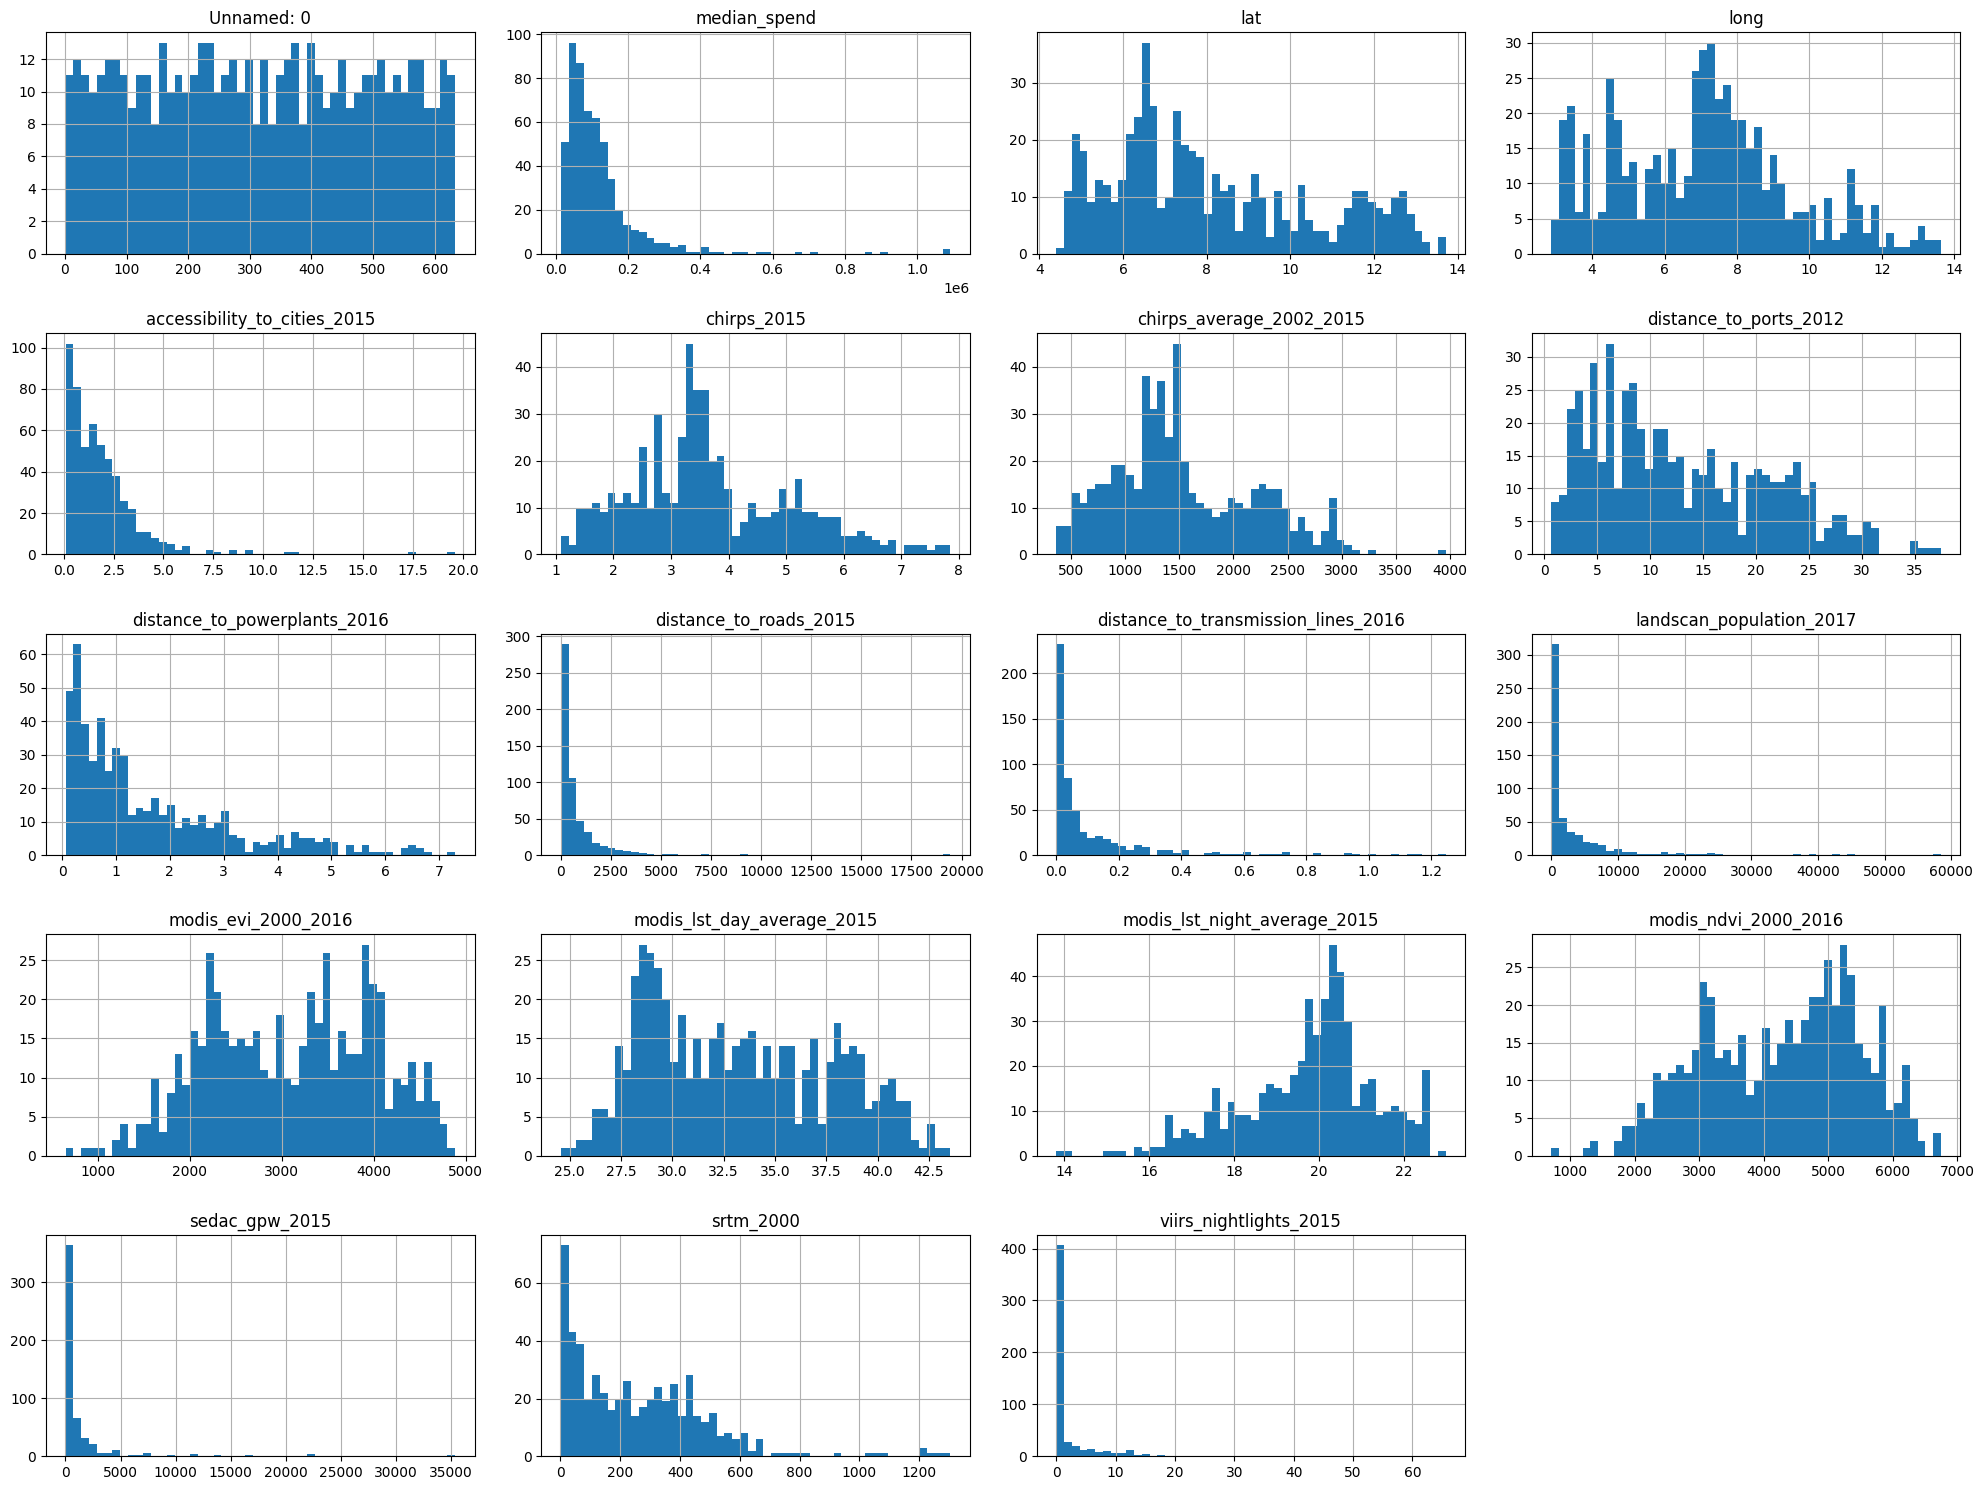

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the unnecessary columns
#data = data.drop(columns=["Unnamed: 0", "lat", "long"])

# Histogram for each feature
data.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

Next, let's plot median_spend on a map to see if there are any insights that present themself visually

<ipython-input-4-d2714b56b310>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


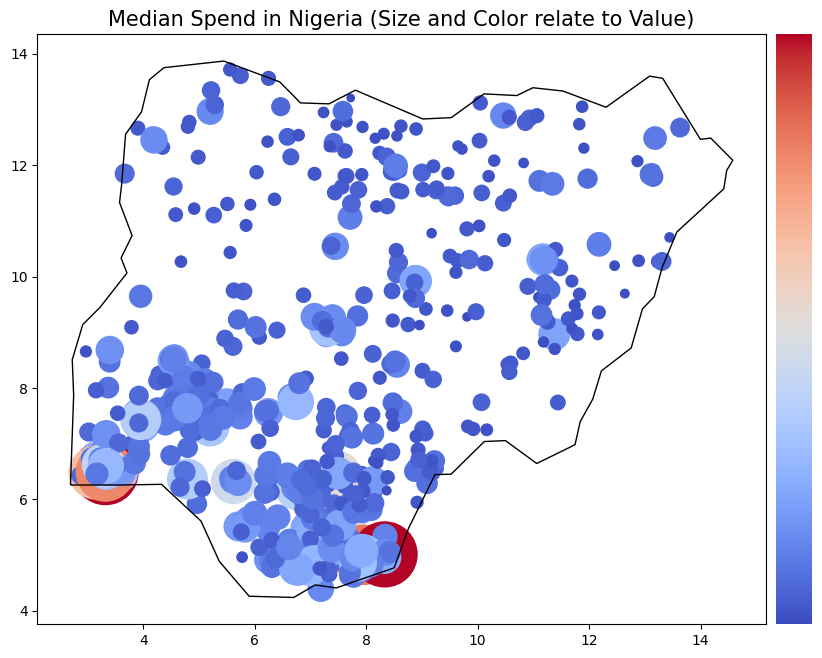

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load Nigeria map (shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select Nigeria
nga = world[world.name == "Nigeria"]

# Create a GeoDataFrame from the data
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.long, data.lat))

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

nga.boundary.plot(ax=ax, linewidth=1, color='black')
gdf.plot(column='median_spend', ax=ax, legend=True, cax=cax, markersize=data['median_spend']/500, cmap='coolwarm', legend_kwds={'label': "Median Spend", 'orientation': "vertical"})

ax.set_title('Median Spend in Nigeria (Size and Color relate to Value)', fontdict={'fontsize': '15', 'fontweight' : '3'})
plt.axis('off')
plt.show()

The map provides some interesting insights:

**Distribution:** The clusters are fairly evenly distributed across Nigeria. There isn't a significant concentration in any specific region, suggesting that the survey was thorough and nationwide.

**Spending:** Higher median spending (represented by larger points) seems to be concentrated more in the southern region of Nigeria. This could be due to factors like higher population densities, more developed infrastructure, and increased access to resources in these areas.

Next we'll make a correlation matrix to identify potentially important features

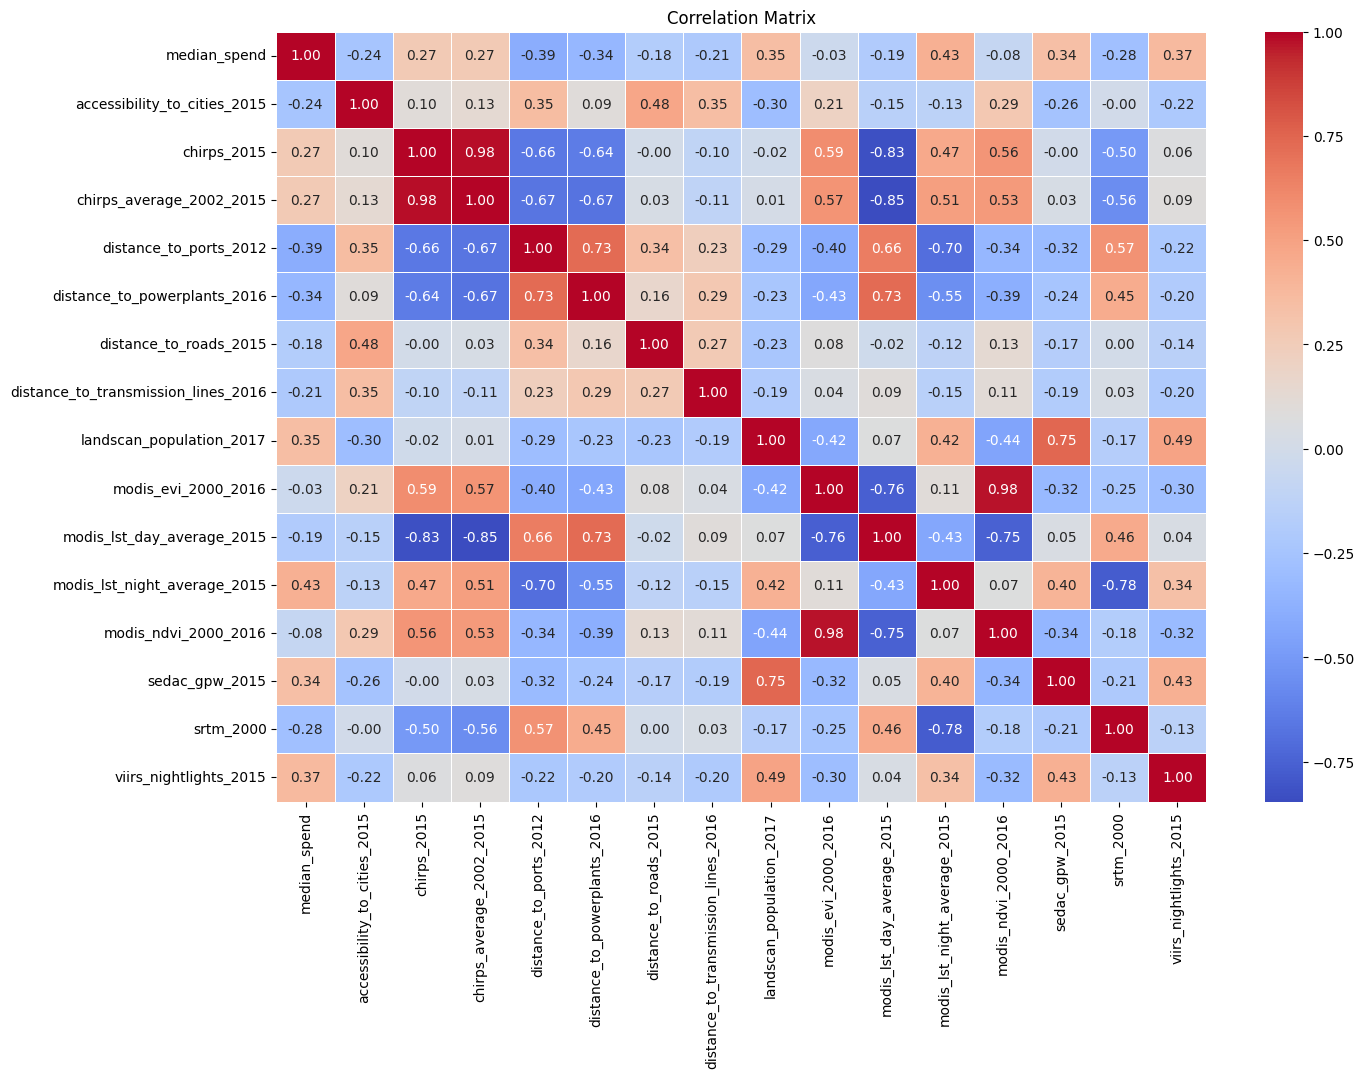

In [7]:
# Drop unnecessary columns
data = data.drop(columns=["Unnamed: 0", "lat", "long"])

# Correlation matrix
corr_matrix = data.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The heatmap of the correlation matrix shows the linear correlation between each pair of features. Values close to 1 or -1 indicate a strong positive or negative correlation, respectively, while values close to 0 indicate a weak or no correlation.

For example, **modis_evi_2000_2016** and **modis_ndvi_2000_2016** have a strong positive correlation of 0.85, indicating that clusters with higher EVI generally also have higher NDVI. The correlation between each feature and **median_spend** can give us an idea of which features might be good predictors for the response variable.

For example, **landscan_population_2017** has a relatively high positive correlation of 0.27 with **median_spend**, suggesting that clusters with higher population might also have higher median spending. However, correlation does not imply causation, and these relationships should be further investigated during the modeling process.

Nest let's compare results from several different models

I chose Mean Absolute Error (MAE) and the Coefficient of Determination (R^2) as evaluation metrics for these reasons:

Mean Absolute Error (MAE): MAE is a straightforward and easily interpretable metric. It represents the average absolute difference between the predicted and actual values, so a lower MAE indicates better performance. MAE is less sensitive to outliers than some other metrics like Mean Squared Error (MSE), because it doesn't square the differences. This can be beneficial if your data has outliers that you don't want to give too much weight to.

Coefficient of Determination (R^2): R^2 represents the proportion of the variance in the target variable that is predictable from the features. It's a number between 0 and 1, where 1 indicates that the model perfectly predicts the target variable and 0 indicates that the model doesn't predict the target variable at all (beyond the mean of the target variable). Negative values indicate a model that is worse than simply predicting the mean of the target variable. R^2 is a very common metric for regression problems because it gives a sense of how well the features explain variation in the target.

               Model           MAE       R^2
0  Linear Regression  73898.608811  0.203718
1      Decision Tree  83625.434865 -0.227601
2      Random Forest  65203.831751  0.352594
3  Gradient Boosting  65700.031155  0.348417


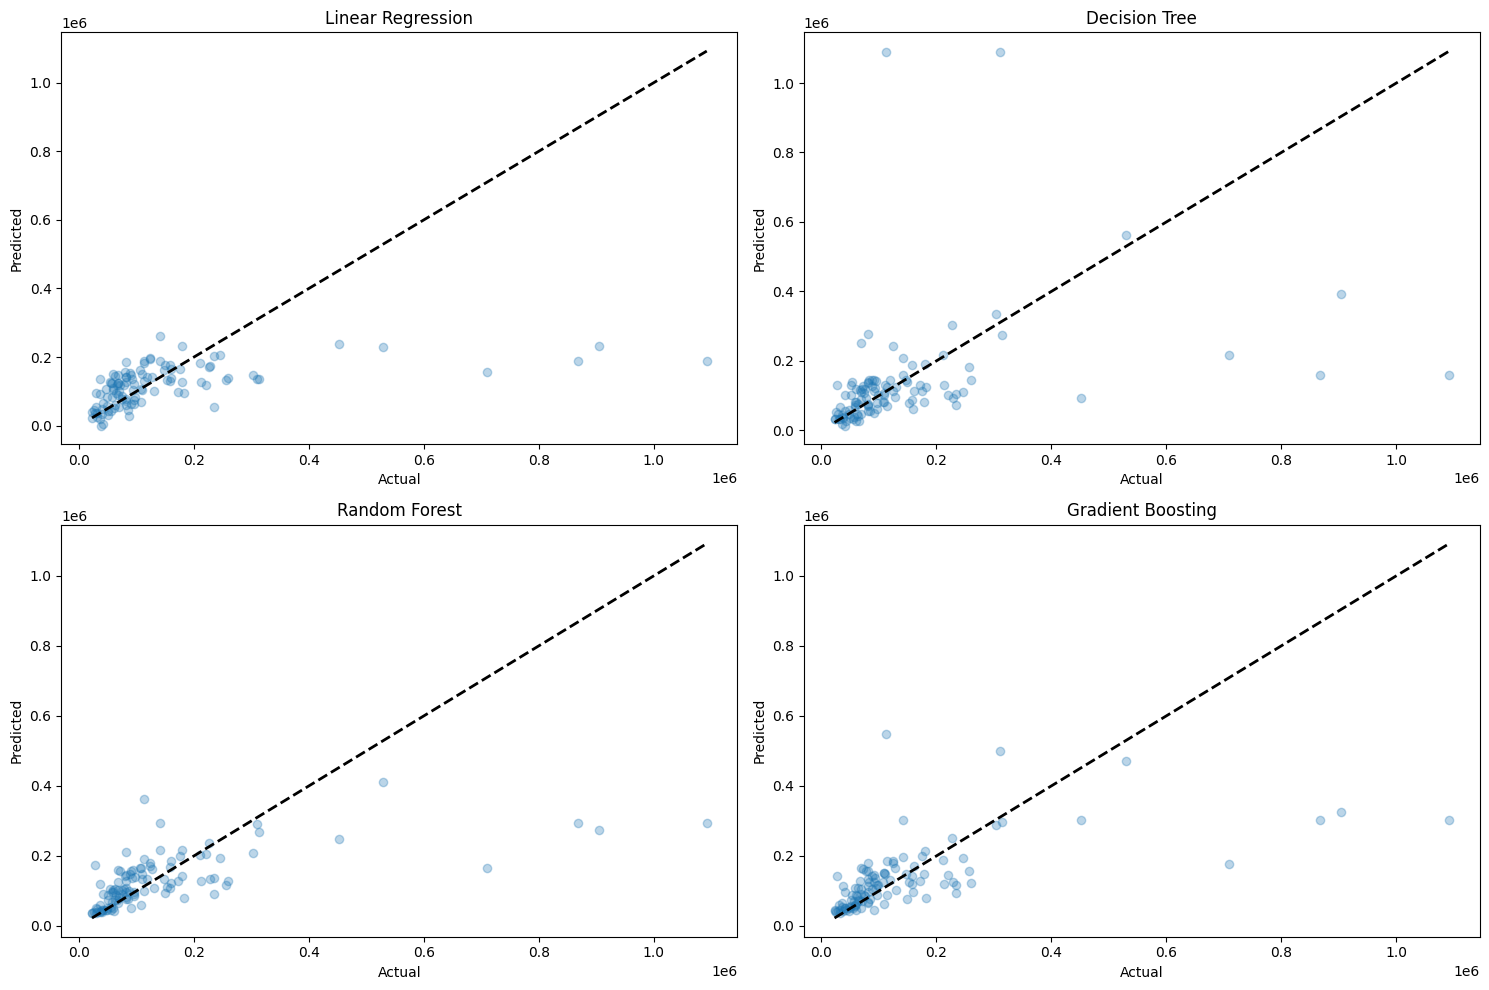

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the features (X) from the target (y)
X = data.drop(columns=["median_spend"])
y = data["median_spend"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the standardized features back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Drop the unnecessary columns
#data = data.drop(columns=["Unnamed: 0", "lat", "long"])

# Check for missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42))
]

# Fit the models and evaluate their performance
results = []

for name, model in models:
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mae, r2))

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Model", "MAE", "R^2"])
print(results_df)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs = axs.ravel()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_scaled)

    axs[i].scatter(y_test, y_pred, alpha=0.3)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title(name)

plt.tight_layout()
plt.show()


The results aren't great but let's see if we can improve results by binning similar features to create some new features to use

               Model           MAE       R^2
0  Linear Regression  73898.608811  0.203718
1      Decision Tree  83499.975495 -0.166834
2      Random Forest  66771.867018  0.362933
3  Gradient Boosting  62745.212423  0.447316


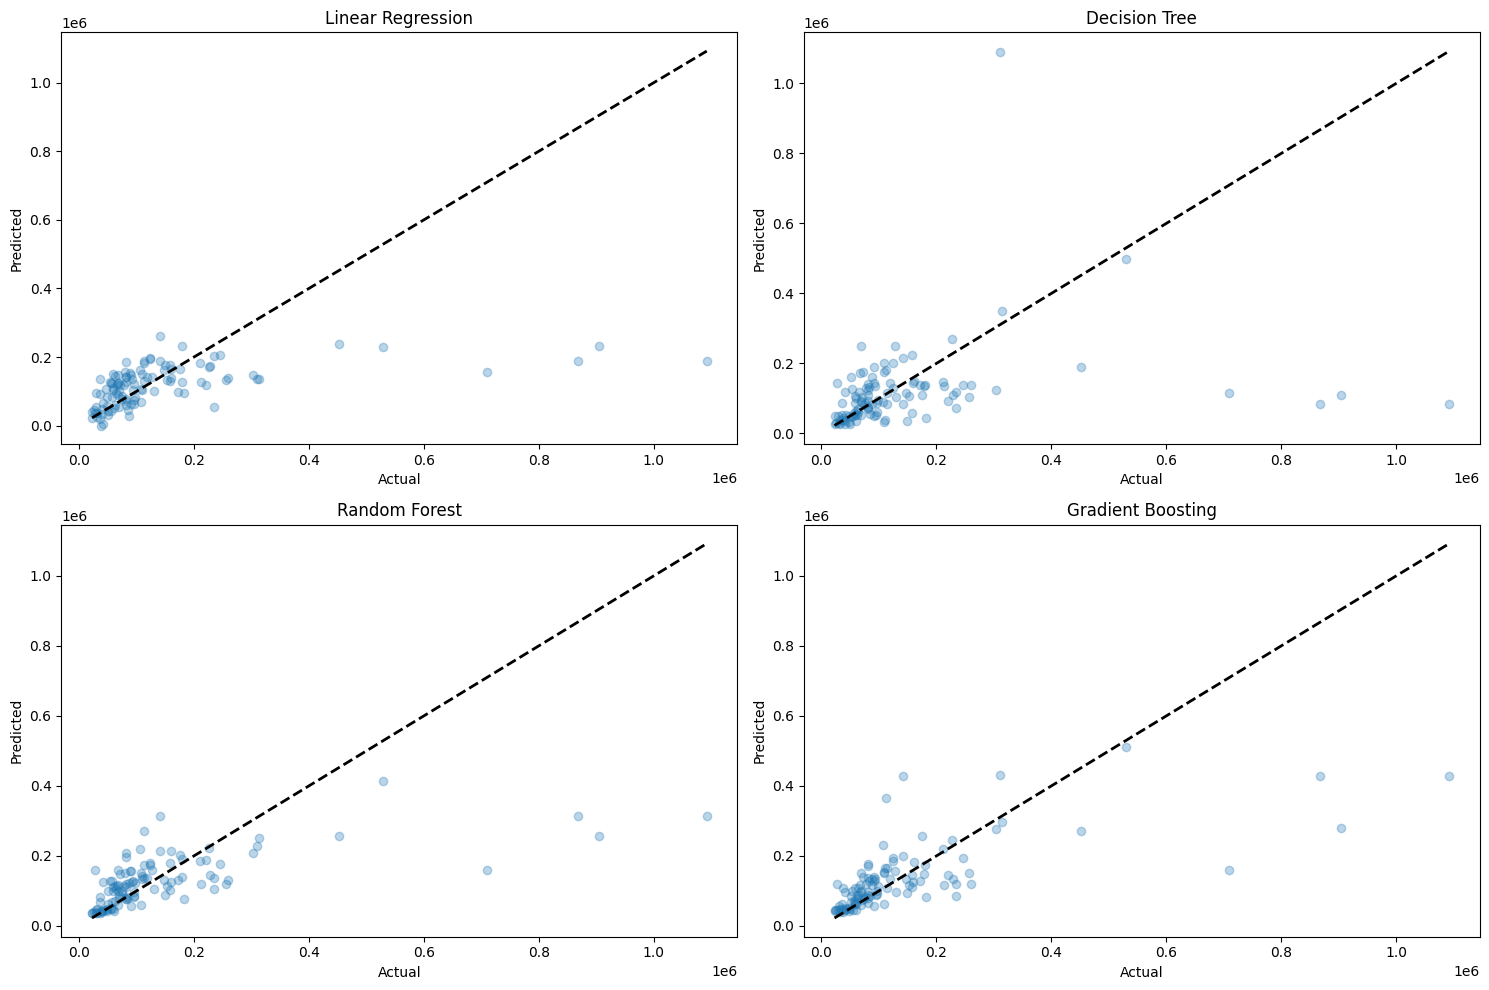

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# Separate the features (X) from the target (y)
X = data.drop(columns=["median_spend"])
y = data["median_spend"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the standardized features back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Define the feature groups
climate_features = ["chirps_2015", "chirps_average_2002_2015", "modis_evi_2000_2016",
                    "modis_lst_day_average_2015", "modis_lst_night_average_2015",
                    "modis_ndvi_2000_2016", "srtm_2000"]
distance_features = ["accessibility_to_cities_2015", "distance_to_ports_2012",
                     "distance_to_powerplants_2016", "distance_to_roads_2015",
                     "distance_to_transmission_lines_2016"]
population_activity_features = ["landscan_population_2017", "sedac_gpw_2015",
                                "viirs_nightlights_2015"]

# Create the new features
X_train_scaled["climate"] = X_train_scaled[climate_features].mean(axis=1)
X_train_scaled["distance"] = X_train_scaled[distance_features].mean(axis=1)
X_train_scaled["population_activity"] = X_train_scaled[population_activity_features].mean(axis=1)

X_test_scaled["climate"] = X_test_scaled[climate_features].mean(axis=1)
X_test_scaled["distance"] = X_test_scaled[distance_features].mean(axis=1)
X_test_scaled["population_activity"] = X_test_scaled[population_activity_features].mean(axis=1)

# Initialize the models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42))
]

# Fit the models and evaluate their performance
results = []

for name, model in models:
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mae, r2))

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Model", "MAE", "R^2"])
print(results_df)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs = axs.ravel()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_scaled)

    axs[i].scatter(y_test, y_pred, alpha=0.3)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title(name)

plt.tight_layout()
plt.show()
